In [1]:
import os
import glob
import pyart
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from scipy import stats

#load up profiles
path = '/g/data1a/kl02/jss548/hail-research/profile_data/*.nc'
profile_file_list = sorted(glob.glob(path))

first_profile = True

for profile_file in profile_file_list:
    with netCDF4.Dataset(profile_file, "r") as ncid:
        refl_data = ncid['refl_prof'][:]
        temp_data = ncid['temp_prof'][:]
        zdr_data  = ncid['zdr_prof'][:]
        rhv_data  = ncid['rhv_prof'][:]
        hsda_data = ncid['hsda_prof'][:]
        hca_data  = ncid['hca_prof'][:]
        hdr_data  = ncid['hdr_prof'][:]
        mesh_data = ncid['mesh_prof'][:]
        alt_data  = ncid['profile_alt'][:]
        
    if first_profile:
        refl_prof     = refl_data
        temp_prof     = temp_data
        zdr_prof      = zdr_data
        rhv_prof      = rhv_data
        hsda_prof     = hsda_data
        hca_prof      = hca_data
        hdr_prof      = hdr_data
        mesh_val      = mesh_data
        alt_vec       = alt_data
        first_profile = False
    else:
        refl_prof = np.append(refl_prof, refl_data, axis = 1)
        temp_prof = np.append(temp_prof, temp_data, axis = 1)
        zdr_prof  = np.append(zdr_prof,  zdr_data, axis = 1)
        rhv_prof  = np.append(rhv_prof,  rhv_data, axis = 1)
        hsda_prof = np.append(hsda_prof, hsda_data, axis = 1)
        hca_prof  = np.append(hca_prof,  hca_data, axis = 1)
        hdr_prof  = np.append(hdr_prof,  hdr_data, axis = 1)
        mesh_val  = np.append(mesh_val, mesh_data)
        
print('data loaded')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: i

data loaded


In [11]:
# prof_sz  = np.shape(refl_prof)
# alt_prof = np.tile(alt_vec, (prof_sz[1], 1))
# alt_prof = np.swapaxes(alt_prof,1,0)

hca_hail_idx = 9 #list of hail classe(s) indices in HCA

#mask hsda at freezing level
hsda_prof[temp_prof < 0] = np.nan
#hsda prof max
# hsda_max = np.nanmax(hsda_prof, axis=0)
hsda_prof[hsda_prof==0] = np.nan

#mode_stats = stats.mode(hsda_prof, axis=0, nan_policy='omit')
#hsda_max   = mode_stats.mode[0] #stat.mode sets null value to 0
hsda_max = np.nanpercentile(hsda_prof, q=75, axis=0, interpolation='nearest')

#mask hca at freezing level
hca_prof[temp_prof < 0] = np.nan
#
hail_flag  = np.any(hca_prof == hca_hail_idx, axis=0)



/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1172: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


In [36]:
#bin mesh

mesh_val_mod = mesh_val ** 1.05


mesh_bins = np.zeros_like(mesh_val_mod)
mesh_bins[mesh_val_mod > 0]   = 1 
mesh_bins[mesh_val_mod > 25]  = 2
mesh_bins[mesh_val_mod > 50]  = 3

#remove entries which have both non-hail hca and mesh 0
mask           = np.invert(np.logical_and(~hail_flag, mesh_bins==0))
hail_flag_mask = hail_flag[mask]
hsda_max_mask  = hsda_max[mask]
mesh_bins_mask = mesh_bins[mask]
mesh_val_mask  = mesh_val_mod[mask]
refl_prof_mask = refl_prof[:,mask]

#check for matches
total       = len(hsda_max_mask)

#check for detection
match_flag        = np.logical_and(mesh_bins_mask>0, hail_flag_mask)
nomesh_hca_flag   = np.logical_and(mesh_bins_mask==0, hail_flag_mask)
mesh_nohca_flag   = np.logical_and(mesh_bins_mask>0, ~hail_flag_mask)
hca_nohsda_flag   = np.logical_and(hsda_max_mask==0, hail_flag_mask)


match_total        = np.sum(match_flag)
nomesh_hca_total   = np.sum(nomesh_hca_flag)
mesh_nohca_total   = np.sum(mesh_nohca_flag)

matches_f  = np.sum(np.invert(match_flag))
matches_f1 = np.sum(hsda_max_mask[np.invert(match_flag)] == 1)
matches_f2 = np.sum(hsda_max_mask[np.invert(match_flag)] == 2)
matches_f3 = np.sum(hsda_max_mask[np.invert(match_flag)] == 3)
matches_f0 = np.sum(hsda_max_mask[np.invert(match_flag)] == 0)

print('HSDA size 0: no hail')
print('HSDA size 1: 0-25 mm')
print('HSDA size 2: 25-50 mm')
print('HSDA size 3: 50+ mm')
print('')

print( 'total detection matches ', round(np.sum(match_total)/total*100), '% of ', total)
print('')
print( 'valid mesh but no Hail HCA ', round(np.sum(nomesh_hca_total)/total*100), '% of ', total)
print( 'Hail HCA but no mesh ', round(np.sum(mesh_nohca_total)/total*100), '% of ', total)
print('')
print( 'Hail HCA but no hsda ', round(np.sum(hca_nohsda_flag)/total*100), '% of ', total)
print('')
print( 'mesh misses for hsda size 0', round(np.sum(matches_f0)/matches_f*100), '% of ', matches_f)
print( 'mesh misses for hsda size 1', round(np.sum(matches_f1)/matches_f*100), '% of ', matches_f)
print( 'mesh misses for hsda size 2', round(np.sum(matches_f2)/matches_f*100), '% of ', matches_f)
print( 'mesh misses for hsda size 3', round(np.sum(matches_f3)/matches_f*100), '% of ', matches_f)
print('')

#check for size matching
matches_sz  = np.sum(mesh_bins_mask == hsda_max_mask)
matches_sz1 = np.sum( np.logical_and(hsda_max_mask==1, mesh_bins_mask==1 ))
matches_sz2 = np.sum( np.logical_and(hsda_max_mask==2, mesh_bins_mask==2 ))
matches_sz3 = np.sum( np.logical_and(hsda_max_mask==3, mesh_bins_mask==3 ))
total1      = np.sum(hsda_max_mask==1)
total2      = np.sum(hsda_max_mask==2)
total3      = np.sum(hsda_max_mask==3)
total0      = np.sum(hsda_max_mask==0)


print( 'percentage of mesh matches:', round(matches_sz/total*100),   '% of', total,  'pixels with HSDA values' )
print('')
print( 'percentage of mesh matches:', round(matches_sz1/total1*100), '% of', total1, 'pixels where HSDA = 1' )
print( 'percentage of mesh matches:', round(matches_sz2/total2*100), '% of', total2, 'pixels where HSDA = 2'  )
print( 'percentage of mesh matches:', round(matches_sz3/total3*100), '% of', total3, 'pixels where HSDA = 3'  )
print( total0, 'HSDA pixels with 0 value not included. This is',round(total0/total*100),'% of the total')

HSDA size 0: no hail
HSDA size 1: 0-25 mm
HSDA size 2: 25-50 mm
HSDA size 3: 50+ mm

total detection matches  71.0 % of  142381

valid mesh but no Hail HCA  3.0 % of  142381
Hail HCA but no mesh  26.0 % of  142381

Hail HCA but no hsda  0.0 % of  142381

mesh misses for hsda size 0 0.0 % of  40991
mesh misses for hsda size 1 7.0 % of  40991
mesh misses for hsda size 2 0.0 % of  40991
mesh misses for hsda size 3 0.0 % of  40991

percentage of mesh matches: 50.0 % of 142381 pixels with HSDA values

percentage of mesh matches: 71.0 % of 95954 pixels where HSDA = 1
percentage of mesh matches: 67.0 % of 1789 pixels where HSDA = 2
percentage of mesh matches: 34.0 % of 5628 pixels where HSDA = 3
0 HSDA pixels with 0 value not included. This is 0.0 % of the total


/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


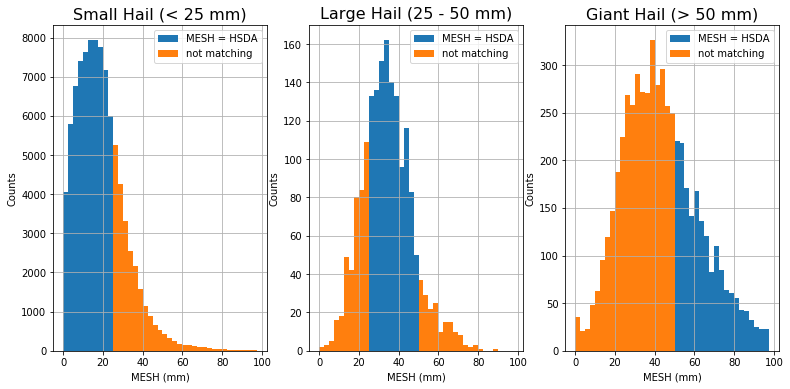

In [37]:
#plot mesh distribution for when size matches and when it fails to match

mesh_val_1 = mesh_val_mask[hsda_max_mask==1]
mesh_val_2 = mesh_val_mask[hsda_max_mask==2]
mesh_val_3 = mesh_val_mask[hsda_max_mask==3]

matches_sz1_tf = mesh_bins_mask[hsda_max_mask==1] == 1
matches_sz2_tf = mesh_bins_mask[hsda_max_mask==2] == 2
matches_sz3_tf = mesh_bins_mask[hsda_max_mask==3] == 3

fig       = plt.figure(figsize=(13, 6), facecolor='w')

plt.subplot(131)
plt.hist(mesh_val_1[matches_sz1_tf], bins=np.arange(0,27.5,2.5), histtype='stepfilled')
plt.hist(mesh_val_1[np.invert(matches_sz1_tf)],  bins=np.arange(25,100,2.5), histtype='stepfilled')
plt.legend(['MESH = HSDA', 'not matching'])
plt.title('Small Hail (< 25 mm)', fontsize=16)
plt.xlabel('MESH (mm)')
plt.ylabel('Counts')
plt.grid()

plt.subplot(132)
plt.hist(mesh_val_2[matches_sz2_tf], bins=np.arange(25,52.5,2.5), histtype='stepfilled')
plt.hist(mesh_val_2[np.invert(matches_sz2_tf)],  bins=np.arange(50,100,2.5), histtype='stepfilled')
plt.hist(mesh_val_2[np.invert(matches_sz2_tf)],  bins=np.arange(0,27.5,2.5), histtype='stepfilled', color='#ff7f0e')
plt.legend(['MESH = HSDA', 'not matching'])
plt.title('Large Hail (25 - 50 mm)', fontsize=16)
plt.xlabel('MESH (mm)')
plt.ylabel('Counts')
plt.grid()

plt.subplot(133)
plt.hist(mesh_val_3[matches_sz3_tf], bins=np.arange(50,100,2.5), histtype='stepfilled')
plt.hist(mesh_val_3[np.invert(matches_sz3_tf)],  bins=np.arange(0,100,2.5), histtype='stepfilled')
plt.legend(['MESH = HSDA', 'not matching'])
plt.title('Giant Hail (> 50 mm)', fontsize=16)
plt.xlabel('MESH (mm)')
plt.ylabel('Counts')
plt.grid()

plt.savefig('mesh_hsda.png',dpi=200)

(142381,)
(41, 142381)
(5628,)
(142381,)
(41, 142381)
(5628,)
(142381,)
(41, 142381)
(5628,)


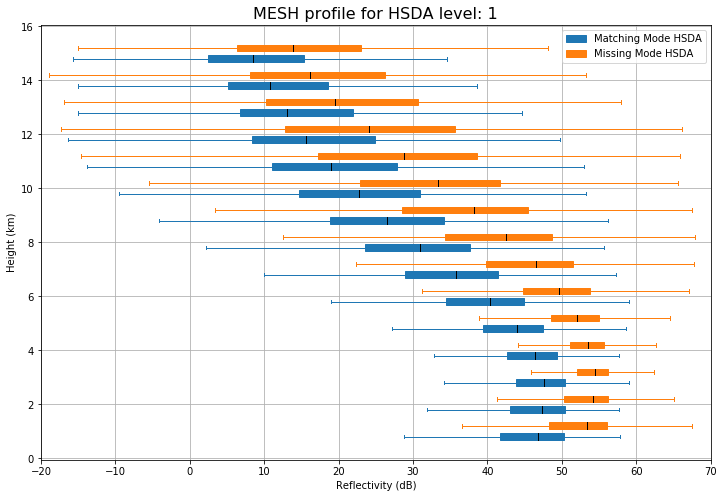

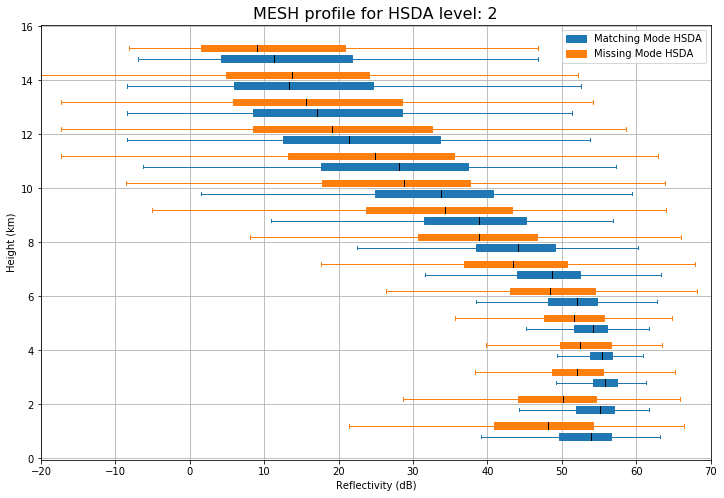

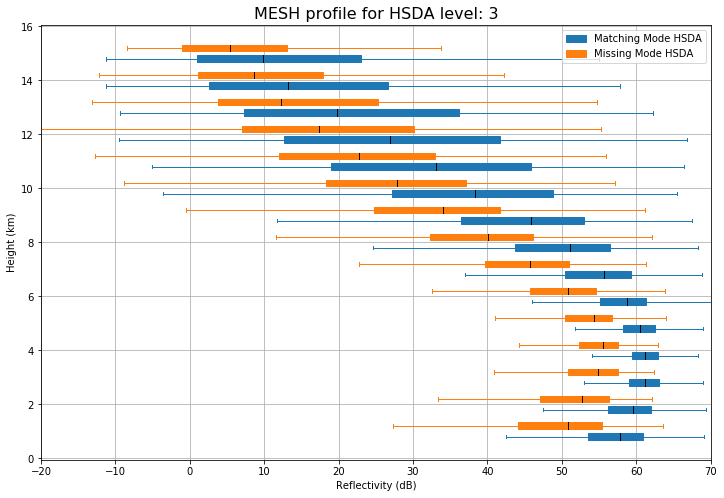

In [38]:
#now generate box plots for 1km height levels of the refl profiles for matching and nonmatching for each hail size

def plot_refl_box(hsda_value):
    print(np.shape(mesh_bins_mask))
    print(np.shape(refl_prof_mask))
    print(np.shape(matches_sz3_tf))

    matches_sz_tf  = mesh_bins_mask[hsda_max_mask==hsda_value] == hsda_value
    refl_prof_hsda = refl_prof_mask[:, hsda_max_mask==hsda_value]

    boxplt_alt_list = np.array(range(1,16))
    refl_match_list = []
    refl_miss_list  = []

    for boxplt_alt in boxplt_alt_list:
        idx = np.where(alt_data/1000 == boxplt_alt)[0][0]
        #build matching data 
        refl_vals       = refl_prof_hsda[idx, matches_sz_tf]
        refl_vals_clean = refl_vals[~np.isnan(refl_vals)]
        refl_match_list.append(refl_vals_clean)
        #build miss data
        refl_vals       = refl_prof_hsda[idx, np.invert(matches_sz_tf)]
        refl_vals_clean = refl_vals[~np.isnan(refl_vals)]
        refl_miss_list.append(refl_vals_clean)


    fig       = plt.figure(figsize=(12, 8), facecolor='w')

    bp1 = plt.boxplot(refl_match_list, 0, '', 0, positions=(boxplt_alt_list)-0.20, manage_xticks=False, widths=0.25, patch_artist=True)
    bp2 = plt.boxplot(refl_miss_list, 0, '', 0, positions=(boxplt_alt_list)+0.20, manage_xticks=False, widths=0.25, patch_artist=True)

    for patch in bp1['boxes']:
            patch.set(facecolor='#1f77b4') 
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
            plt.setp(bp1[element], color='#1f77b4')
    for patch in bp2['boxes']:
            patch.set(facecolor='#ff7f0e') 
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
            plt.setp(bp2[element], color='#ff7f0e')
    plt.setp(bp1['medians'], color='k')        
    plt.setp(bp2['medians'], color='k')        

    plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Matching Mode HSDA','Missing Mode HSDA'], loc='upper right')
    plt.title('MESH profile for HSDA level: ' + str(hsda_value), fontsize=16)
    plt.xlabel('Reflectivity (dB)')
    plt.ylabel('Height (km)')
    plt.xlim([-20,70])
    plt.grid()
    
plot_refl_box(1)
plot_refl_box(2)
plot_refl_box(3)